In [1]:
%matplotlib inline
from skimage import io, filters
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from lgan.diffeomorphism import tf_diffeomorphism

In [2]:
batch_size = 64 #batch size
input_dim = 784 #dim x and z input_size

#mnist data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
X_train = mnist.train.images
Y_train = mnist.train.labels
X_train = X_train.reshape(55000,28,28,1)

#reorganize labels
y_train = np.zeros(55000)
for i in range(len(Y_train)):
    y_train[i]= np.argwhere(Y_train[i]==1)#reshape

#create mean Images
numberImages = np.zeros((10,28,28,1))
for i in range(10):
    numbers = np.argwhere(y_train==i)
    z = X_train[numbers] #collect all images with number    
    numberImages[i] = np.mean(z, axis=0)

X_train = X_train.reshape(55000,784)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
#simple plot function
def plot(samples, labels):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    plt.subplots_adjust(left=None, bottom=None, right=1, top=1.3,
                wspace=None, hspace=None)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.title(labels[i])
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')   
    return fig

In [4]:
#sample for Generator: Random Mean Images 0-9 + Uniform Noise Vector + Label
def sample_z(batch_size):
    batch = np.zeros((batch_size,input_dim))
    labels = np.zeros((batch_size,))
    for i in range(batch_size-1):
        vector = np.random.uniform(-1., 1., size=[input_dim])/20
        index = int(np.random.rand(1)*10)
        number = np.reshape(numberImages[index],784)
        z_im = number+vector
        batch[i]=z_im
        labels[i]=index
    return (batch,labels)

In [5]:
def generator(z):
    with tf.variable_scope('generator'):
        z = tf.reshape(z,[-1,28,28,1])
        net = slim.conv2d(z, 32, [3, 3],2, weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                          scope='convG_1',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        net = slim.conv2d(net, 64, [3, 3],1, weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                          scope='convG_2',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        net = slim.convolution2d_transpose(net, 32, [3,3],2, weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                          scope='convG_3',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        net = slim.conv2d(net, 1, [1,1],1, weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                          scope='convG_4',padding = 'SAME')
        G_prob = tf.nn.tanh(net)
        return G_prob


def discriminator(x):
    with tf.variable_scope('discriminator'):
        x = tf.reshape(x,[-1,28,28,1])
        #net = slim.conv2d(x, 128, [3, 3], weights_initializer=tf.contrib.layers.xavier_initializer(), scope='convD_1')
        #net = slim.batch_norm(net)
        #net = tf.nn.relu(net)
        net = slim.conv2d(x, 32, [3, 3],2,weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                          scope='convD_2',padding = 'SAME')
        net = tf.nn.relu(net)
        net = slim.conv2d(net, 64, [3, 3],1,weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                          scope='convD_3',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        net = slim.convolution2d_transpose(net, 32, [3,3],2, weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                          scope='convD_4',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        net = slim.conv2d(net, 16, [3,3],1, weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                          scope='convD_5',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        return slim.fully_connected(net, num_outputs = 1,weights_initializer=tf.truncated_normal_initializer(stddev=0.1))


In [ ]:
#Session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)


#input
X = tf.placeholder(tf.float32, shape=[None, input_dim]) 
z = tf.placeholder(tf.float32, shape=[None, input_dim])

#Models
G_sample = generator(z)
D_real = discriminator(X)
D_fake = discriminator(G_sample)

#variables V1
theta_D1 = sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator') 
theta_G1 = sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')

D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
G_loss = -tf.reduce_mean(D_fake)

D_solver = (tf.train.RMSPropOptimizer(learning_rate=1e-4)
            .minimize(-D_loss, var_list=theta_D1))
G_solver = (tf.train.RMSPropOptimizer(learning_rate=1e-4)
            .minimize(G_loss, var_list=theta_G1))

clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in theta_D1]


if not os.path.exists('out/'):
    os.makedirs('out/')

#initalize Variables    
sess.run(tf.global_variables_initializer())    

Pretrain Step  0
Pretrain Step  1
Pretrain Step  2
Pretrain Step  3
Pretrain Step  4
Pretrain Step  5
Pretrain Step  6
Pretrain Step  7
Pretrain Step  8
Pretrain Step  9
Pretrain Step  10
Pretrain Step  11
Pretrain Step  12
Pretrain Step  13
Pretrain Step  14
Pretrain Step  15
Pretrain Step  16
Pretrain Step  17
Pretrain Step  18
Pretrain Step  19
Pretrain Step  20
Pretrain Step  21
Pretrain Step  22
Pretrain Step  23
Pretrain Step  24
Pretrain Step  25
Pretrain Step  26
Pretrain Step  27
Pretrain Step  28
Pretrain Step  29
Pretrain Step  30
Pretrain Step  31
Pretrain Step  32
Pretrain Step  33
Pretrain Step  34
Pretrain Step  35
Pretrain Step  36
Pretrain Step  37
Pretrain Step  38
Pretrain Step  39
Pretrain Step  40
Pretrain Step  41
Pretrain Step  42
Pretrain Step  43
Pretrain Step  44
Pretrain Step  45
Pretrain Step  46
Pretrain Step  47
Pretrain Step  48
Pretrain Step  49
Pretrain Step  50
Pretrain Step  51
Pretrain Step  52
Pretrain Step  53
Pretrain Step  54
Pretrain Step  55
Pr

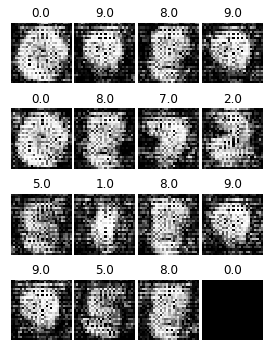

Iter: 100; D loss: 0.03773; G_loss: -5.09e-05
Iter: 200; D loss: 0.03805; G_loss: -6.791e-05
Iter: 300; D loss: 0.03665; G_loss: -0.002664
Iter: 400; D loss: 0.01317; G_loss: -0.007152
Iter: 500; D loss: 0.01523; G_loss: -0.01139
Iter: 600; D loss: 0.01423; G_loss: -0.003095
Iter: 700; D loss: 0.01026; G_loss: -0.00935
Iter: 800; D loss: 0.01451; G_loss: -0.01531
Iter: 900; D loss: 0.01197; G_loss: -0.003427
Iter: 1000; D loss: 0.01305; G_loss: -0.007358
(28, 28, 1)


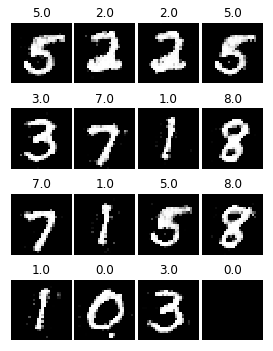

Iter: 1100; D loss: 0.01186; G_loss: -0.003148
Iter: 1200; D loss: 0.0121; G_loss: -0.01205
Iter: 1300; D loss: 0.009761; G_loss: -0.0112
Iter: 1400; D loss: 0.01379; G_loss: -0.01334
Iter: 1500; D loss: 0.01409; G_loss: -0.004076
Iter: 1600; D loss: 0.01486; G_loss: -0.002704
Iter: 1700; D loss: 0.0151; G_loss: -0.002454
Iter: 1800; D loss: 0.01452; G_loss: -0.001698
Iter: 1900; D loss: 0.01442; G_loss: -0.01079
Iter: 2000; D loss: 0.01222; G_loss: -0.008624
(28, 28, 1)


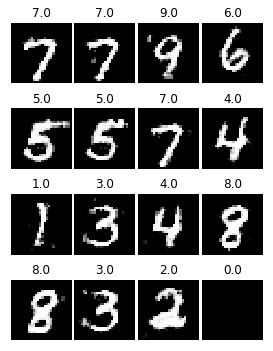

Iter: 2100; D loss: 0.01582; G_loss: -0.01089
Iter: 2200; D loss: 0.01595; G_loss: -0.009737


In [ ]:
#pretrain disc:
for t in range(100):
    #train discriminator
    Xdata, _ = mnist.train.next_batch(batch_size)
    (im, labels) = sample_z(batch_size) #get Image Batch+Labels
    print("Pretrain Step ",t)
    _, D_loss_curr, _ = sess.run(
        [D_solver, D_loss, clip_D],
        feed_dict={X: Xdata, z: im}
    ) 
    
i = 0
for it in range(100000):
    for _ in range(5): #train discriminator
        Xdata, _ = mnist.train.next_batch(batch_size)
        (im, labels) = sample_z(batch_size) #get Image Batch+Labels
        _, D_loss_curr, _ = sess.run(
            [D_solver, D_loss, clip_D],
            feed_dict={X: Xdata, z: im}
        )
    (im, labels) = sample_z(batch_size) #get Image Batch+Labels
    _, G_loss_curr = sess.run(
        [G_solver, G_loss],
        feed_dict={z: im}
    )

    if it % 100 == 0:
        print('Iter: {}; D loss: {:.4}; G_loss: {:.4}'
              .format(it, D_loss_curr, G_loss_curr))
        if it % 1000 == 0:
            (im, labels) = sample_z(16) #get Image Batch+Labels
            samples = sess.run(G_sample, feed_dict={z: im})
            print(samples[0].shape)
            fig = plot(samples, labels)
            plt.savefig('out/{}.png'
                        .format(str(i).zfill(3)), bbox_inches='tight')
            plt.show()
            i += 1
plt.close(fig)